In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from aicentro.session import Session
sacp_session = Session(verify=False)
from aicentro.framework.framework import BaseFramework as SacpFrm
sacp_framework = SacpFrm(session=sacp_session)

###  <b>데이터 불러오기
---
- 학습 데이터 불러오기

In [2]:
Train_Data = pd.read_csv('TrainData.csv',delimiter=',')

### <b>데이터 전처리
---

In [3]:
Train_Data=Train_Data.drop_duplicates()

In [4]:
Train_Data['Result_v1'].replace({'benign':1,'malicious':-1}, inplace=True)

In [5]:
Train_Data.drop(columns=["url_chinese_present","html_num_tags('applet')"],inplace=True)

In [6]:
Train_Data = Train_Data.dropna(axis=0)

In [7]:
X = Train_Data.iloc[:,0:len(Train_Data.columns)-1].values
y = Train_Data.iloc[:,len(Train_Data.columns)-1].values

#### train_test_split을 이용하여, train_x, val_x, train_y, val_y로 데이터 분리
---

- test_size = 0.3
- random_state = 2021

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# train_test_split 사용
train_x, val_x, train_y, val_y = train_test_split(X, y,test_size=0.3,random_state=2021) 

In [10]:
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((3632, 41), (1557, 41), (3632,), (1557,))

### <b>Confusion Matrix 함수 정의
---

In [11]:
from sklearn.metrics import classification_report as creport
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [12]:
def plot_confusion_matrix(ax, matrix, labels = ['malicious','benign'], title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Blues)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()

### <b>RandomForest GridSearchCV
---
 - 참고사이트 : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
 - 참고사이트 : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
param_grid = [ {'n_estimators':[30,40,50,60,100], 'max_depth':[30,40,50,60,100]}]

In [15]:
rfc = RandomForestClassifier()

In [16]:
rfc_grid = GridSearchCV(rfc, 
                        param_grid, # 
                        cv=2, 
                        scoring='accuracy', # Classification일때  'accuracy','f1' ...
                                            # Regression 일때 'neg_mean_squared_error','r2'...
                        n_jobs=-1,          
                        verbose=1           # Log 출력 Level 조정
                       )

In [17]:
rfc_grid.fit(train_x, train_y)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.6s finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_depth': [30, 40, 50, 60, 100],
                          'n_estimators': [30, 40, 50, 60, 100]}],
             scoring='accuracy', verbose=1)

In [18]:
rfc_model = rfc_grid.best_estimator_

In [19]:
print('최적의 파라미터 값 : ', rfc_grid.best_params_)
print('최고의 점수 : ', rfc_grid.best_score_)

최적의 파라미터 값 :  {'max_depth': 100, 'n_estimators': 100}
최고의 점수 :  0.9592511013215859


In [20]:
rfc_grid_pred = rfc_model.predict(val_x)

In [21]:
# train 및 val 데이터 정확도
rfc_model.score(train_x, train_y), rfc_model.score(val_x, val_y)

(1.0, 0.9710982658959537)

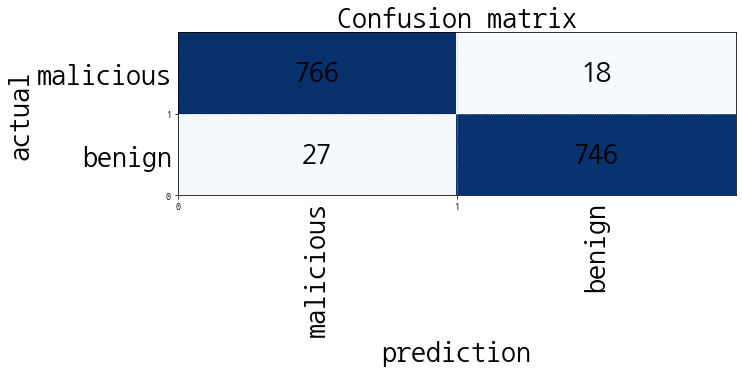

In [22]:
#Confusion Matrix
confusion = confusion_matrix(val_y, rfc_grid_pred)
fig, ax = plt.subplots(figsize=(10,3))
plot_confusion_matrix(ax, confusion, fontsize=30)

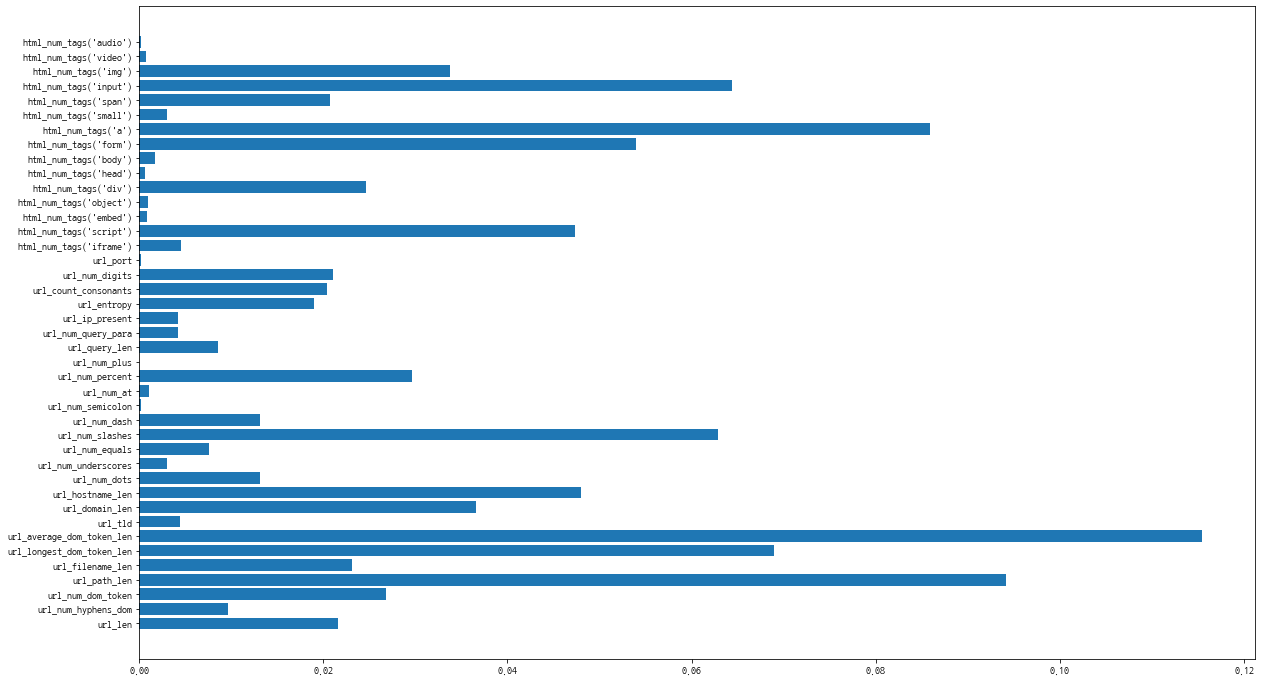

In [23]:
# feature_importances_ 활용 Feature별 가중치 확인
plt.figure(figsize=(20,12))
plt.barh(y=Train_Data.columns[:-1],
        width = rfc_model.feature_importances_)
plt.show()